In [ ]:
# Add these at the top of your notebook cell
import matplotlib
matplotlib.use('inline')  # or 'Agg'
import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode

# Also add this to force display
%matplotlib inline
import torchvision.transforms.v2 as T

In [ ]:
def get_imc_transforms(image_size=(256, 256)):
    train_transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
       T.RandomRotation(degrees=(-90, 90)),
        T.RandomAffine(degrees=10,translate=(0.05, 0.05)),
        T.Resize(image_size, antialias=True),
    ])
    val_transform = T.Compose([
        T.Resize(image_size, antialias=True),
    ])
    return train_transform, val_transform

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import tifffile
from typing import Tuple, Optional, List, Dict
import logging
import re

class IMCDataset(Dataset):
    """Dataset for IMC (Imaging Mass Cytometry) data for tissue type and condition prediction"""
    
    def __init__(
        self,
        data_dir: str,
        transform=None,
        target_transform=None,
        use_mask: bool = False,
        channels: Optional[List[int]] = None,
        image_size: Optional[Tuple[int, int]] = None,
        normalize: bool = True,
        arcsinh_transform: bool = True,
        cofactor: float = 5.0,
        classification_task: str = "condition",  # "condition" (Benign vs Malignant) - "tissue" and "both" removed since we only have prostate data
        split: str = "train"
    ):
        """
        Args:
            data_dir: Directory containing ROI folders
            transform: Optional transform to be applied on images
            target_transform: Optional transform to be applied on labels
            use_mask: Whether to use the mask.tiff files
            channels: List of channel indices to use (if None, uses all)
            image_size: Size to resize images to (height, width)
            normalize: Whether to normalize channels
            arcsinh_transform: Whether to apply arcsinh transformation
            cofactor: Cofactor for arcsinh transformation
            classification_task: What to predict - "tissue", "condition", or "both"
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.use_mask = use_mask
        self.channels = channels
        self.image_size = image_size
        self.normalize = normalize
        self.arcsinh_transform = arcsinh_transform
        self.cofactor = cofactor
        self.classification_task = classification_task
        
        # Scan directory and parse folder names
        self.samples = self._scan_directory()
        
        # Create label mappings based on classification task
        self._create_label_mappings()
        
        logging.info(f"Loaded {len(self.samples)} samples")
        logging.info(f"Classification task: {self.classification_task}")
        logging.info(f"Labels: {self.unique_labels}")

        # Set transforms if not provided
        if transform is None and image_size is not None:
            train_transform, val_transform = get_imc_transforms(image_size)
            self.transform = train_transform if split == "train" else val_transform
        else:
            self.transform = transform
        
    def _scan_directory(self):
        """Scan directory for ROI folders and parse information"""
        samples = []
        
        for roi_folder in self.data_dir.glob("ROI*"):
            if not roi_folder.is_dir():
                continue
                
            # Parse folder name: ROI###_TISSUE_[Benign_]TMA###[N]
            folder_name = roi_folder.name
            
            # Extract ROI number
            roi_match = re.match(r"ROI(\d+)", folder_name)
            if not roi_match:
                continue
            roi_num = int(roi_match.group(1))
            
            # Extract tissue type
            parts = folder_name.split('_')
            if len(parts) < 3:
                continue
            tissue = parts[1]  # PROSTATE, LIVER, KIDNEY
            
            # Determine if benign or malignant
            if "Benign" in folder_name:
                condition = "Benign"
            else:
                condition = "Malignant"
            
            # Check if image files exist
            imc_path = roi_folder / "input" / "imc"
            if not imc_path.exists():
                continue
                
            # Look for .ome.tiff file
            ome_files = list(imc_path.glob("*.ome.tiff"))
            if not ome_files:
                continue
            image_file = ome_files[0]
            
            # Look for mask file if needed
            mask_file = None
            if self.use_mask:
                mask_files = list(imc_path.glob("*_mask.tiff"))
                if mask_files:
                    mask_file = mask_files[0]
            
            samples.append({
                'roi_num': roi_num,
                'tissue': tissue,
                'condition': condition,
                'folder_name': folder_name,
                'image_path': image_file,
                'mask_path': mask_file,
                'roi_folder': roi_folder
            })
        
        return samples
    
    def _create_label_mappings(self):
        """Create label mappings based on classification task"""
        if self.classification_task == "tissue":
            labels = [sample['tissue'] for sample in self.samples]
        elif self.classification_task == "condition":
            labels = [sample['condition'] for sample in self.samples]
        elif self.classification_task == "both":
            labels = [f"{sample['tissue']}_{sample['condition']}" for sample in self.samples]
        else:
            raise ValueError("classification_task must be 'tissue', 'condition', or 'both'")
        
        self.unique_labels = sorted(list(set(labels)))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = self._load_image(sample['image_path'])
        
        # Load mask if needed
        mask = None
        if self.use_mask and sample['mask_path']:
            mask = self._load_mask(sample['mask_path'])
        
        # Get label based on classification task
        if self.classification_task == "tissue":
            label = sample['tissue']
        elif self.classification_task == "condition":
            label = sample['condition']
        elif self.classification_task == "both":
            label = f"{sample['tissue']}_{sample['condition']}"
        
        label_idx = self.label_to_idx[label]
        
        # Apply transforms
        if self.transform:
            print(" Applying transform")
            image = self.transform(image)
        
        if self.target_transform:
            label_idx = self.target_transform(label_idx)
        
        if mask is not None:
            return image, label_idx, mask
        else:
            return image, label_idx
    
    def _load_image(self, img_path: Path) -> torch.Tensor:
        """Load and preprocess IMC image"""
        # Load OME-TIFF image
        img = tifffile.imread(str(img_path))
        
        # Ensure image is float32
        img = img.astype(np.float32)
        
        # Handle different image shapes
        if img.ndim == 2:
            # Single channel image
            img = img[np.newaxis, ...]  # Add channel dimension
        elif img.ndim == 3:
            # Multi-channel image - OME-TIFF usually has channels first
            # If channels are last, transpose
            if img.shape[2] < img.shape[0]:
                img = np.transpose(img, (2, 0, 1))
        
        # Select specific channels if specified
        if self.channels is not None:
            img = img[self.channels]
        
        # Apply arcsinh transformation (common for mass cytometry data)
        if self.arcsinh_transform:
            img = np.arcsinh(img / self.cofactor)
        
        # Normalize each channel
        if self.normalize:
            for c in range(img.shape[0]):
                channel = img[c]
                if channel.std() > 0:
                    img[c] = (channel - channel.mean()) / channel.std()
        
        # Resize if needed
        if self.image_size is not None and self.image_size != img.shape[1:]:
            img = torch.nn.functional.interpolate(
                torch.from_numpy(img).unsqueeze(0),
                size=self.image_size,
                mode='bilinear',
                align_corners=False
            ).squeeze(0).numpy()
        
        return torch.from_numpy(img)
    
    def _load_mask(self, mask_path: Path) -> torch.Tensor:
        """Load segmentation mask"""
        mask = tifffile.imread(str(mask_path))
        return torch.from_numpy(mask.astype(np.int64))
    
    def get_class_weights(self):
        """Calculate class weights for imbalanced datasets"""
        if self.classification_task == "tissue":
            labels = [sample['tissue'] for sample in self.samples]
        elif self.classification_task == "condition":
            labels = [sample['condition'] for sample in self.samples]
        elif self.classification_task == "both":
            labels = [f"{sample['tissue']}_{sample['condition']}" for sample in self.samples]
        
        from collections import Counter
        label_counts = Counter(labels)
        total_samples = len(self.samples)
        
        weights = []
        for label in self.unique_labels:
            weight = total_samples / (len(self.unique_labels) * label_counts[label])
            weights.append(weight)
        
        return torch.FloatTensor(weights)


def create_dataloaders(
    data_dir: str,
    train_split: float = 0.8,
    batch_size: int = 32,
    num_workers: int = 4,
    pin_memory: bool = True,
    random_seed: int = 42,
    **dataset_kwargs
) -> Tuple[DataLoader, DataLoader, Dict]:
    """Create training and validation dataloaders from a single directory"""
    
    # Create full dataset
    full_dataset = IMCDataset(
        data_dir=data_dir,
        **dataset_kwargs
    )
    
    # Check if we have any samples left after filtering
    if len(full_dataset) == 0:
        raise ValueError("No valid samples found after filtering single-sample classes")
    
    # For condition classification with filtered data, we can do stratified split
    try:
        from sklearn.model_selection import train_test_split
        
        # Get labels for stratification
        if full_dataset.classification_task == "tissue":
            labels = [sample['tissue'] for sample in full_dataset.samples]
        elif full_dataset.classification_task == "condition":
            labels = [sample['condition'] for sample in full_dataset.samples]
        else:
            labels = [f"{sample['tissue']}_{sample['condition']}" for sample in full_dataset.samples]
        
        # Try stratified split
        indices = list(range(len(full_dataset)))
        train_idx, val_idx = train_test_split(
            indices, 
            train_size=train_split,
            stratify=labels,
            random_state=random_seed
        )
        
        train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
        val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
        
        print("✅ Using stratified split (ensures each class in both train/val)")
        
    except (ImportError, ValueError) as e:
        # Fall back to random split if sklearn not available or stratification fails
        print(f"⚠️ Stratified split failed ({e}), using random split")
        torch.manual_seed(random_seed)
        train_size = int(train_split * len(full_dataset))
        val_size = len(full_dataset) - train_size
        
        # Stratified split
        train_dataset = torch.utils.data.Subset(
            IMCDataset(data_dir=data_dir, split="train", **dataset_kwargs), train_idx
        )
        val_dataset = torch.utils.data.Subset(
            IMCDataset(data_dir=data_dir, split="val", **dataset_kwargs), val_idx
        )

    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False
    )
    
    # Get dataset info
    dataset_info = {
        'num_classes': len(full_dataset.unique_labels),
        'class_names': full_dataset.unique_labels,
        'class_weights': full_dataset.get_class_weights(),
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'total_samples': len(full_dataset),
        'classification_task': full_dataset.classification_task
    }
    
    # Print summary
    print(f"📊 Dataset Summary:")
    print(f"   Classification task: {dataset_info['classification_task']}")
    print(f"   Classes: {dataset_info['class_names']}")
    print(f"   Total samples: {dataset_info['total_samples']}")
    print(f"   Train samples: {dataset_info['train_size']}")
    print(f"   Val samples: {dataset_info['val_size']}")
    
    return train_loader, val_loader, dataset_info


# Example usage
if __name__ == "__main__":
    # Simplified example for prostate cancer classification
    train_loader, val_loader, dataset_info = create_dataloaders(
        data_dir="./data",  # Your symlinked data directory
        classification_task="condition",  # Benign vs Malignant (recommended)
        batch_size=16,
        use_mask=False,  # Set to True if you want to use segmentation masks
        channels=None,  # Use all channels, or specify subset like [0, 5, 10]
        image_size=(256, 256),  # Resize images
        arcsinh_transform=True,
        cofactor=5.0,
        train_split=0.8
    )
    
    print(f"🎯 Prostate Cancer Classification Setup")
    print(f"Classes: {dataset_info['class_names']}")  # Should be ['Benign', 'Malignant']
    print(f"Train samples: {dataset_info['train_size']}")
    print(f"Val samples: {dataset_info['val_size']}")
    
    # Test the dataloader
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Batch {batch_idx}: Images shape: {images.shape}, Labels: {labels}")
        # Decode labels to see class names
        label_names = [dataset_info['class_names'][label.item()] for label in labels]
        print(f"Label names: {label_names}")
        if batch_idx == 0:
            break

In [ ]:
# Get one batch and visualize just one image
for batch_idx, (images, labels) in enumerate(train_loader):
    # Get first image
    first_image = images[0]  # Shape: (62, 128, 128)
    first_label = labels[0].item()
    
    print(f"Image shape: {first_image.shape}")
    print(f"Label: {first_label} ({dataset_info['class_names'][first_label]})")
    
    # Show first 6 channels
    fig, axes = plt.subplots(4, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for i in range(12):
        channel_data = first_image[i].numpy()
        im = axes[i].imshow(channel_data, cmap='viridis')
        axes[i].set_title(f'Channel {i}')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    break

In [ ]:
from sympy import Ge
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.ops import DropBlock2d
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torch.nn.functional as F
import torchvision.models as models
from typing import List, Tuple, Optional


class EfficientNetMarkerEncoder(nn.Module):
    """EfficientNet-B3 based marker encoder for individual IMC marker channels"""
    def __init__(self, feature_dim: int = 128, pretrained: bool = True, dropout_rate: float = 0.3):
        super(EfficientNetMarkerEncoder, self).__init__()
        self.feature_dim = feature_dim
        
        # Load the pretrained EfficientNet-B3 model
        if pretrained:
            weights = models.EfficientNet_B3_Weights.DEFAULT
        else:
            weights = None
            
        self.backbone = models.efficientnet_b3(weights=weights)
        
        # EfficientNet-B3 output features from the last layer before classifier
        # EfficientNet classifier is a Sequential with a Dropout and Linear layer
        backbone_out_features = self.backbone.classifier[1].in_features  # 1792 for EfficientNet-B4
        
        # Modify the first layer to accept a single channel input
        original_first_conv = self.backbone.features[0][0]
        self.backbone.features[0][0] = nn.Conv2d(
            in_channels=1,
            out_channels=original_first_conv.out_channels,
            kernel_size=original_first_conv.kernel_size,
            stride=original_first_conv.stride,
            padding=original_first_conv.padding,
            bias=False
        )
        
        # Remove final classification layers but keep the avgpool and flatten
        self.backbone.classifier = nn.Identity()
        
        # Store the avgpool and flatten operations explicitly
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

        # Adding custom feature head
        self.feature_head = nn.Sequential(
            nn.LayerNorm(backbone_out_features),
            nn.Linear(backbone_out_features, 512),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, feature_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # x shape: [batch_size, 1, H, W]
        # Extract features from backbone (before classifier)
        features = self.backbone.features(x)  # [batch_size, 1792, H', W']
        features = self.avgpool(features)  # [batch_size, 1792, 1, 1]
        features = self.flatten(features)  # [batch_size, 1792]
        features = self.feature_head(features)
        return features


class SimpleFusionHead(nn.Module):
    """Simple fusion head using average pooling instead of attention"""
    def __init__(self, feature_dim=128, num_markers=62, num_classes=2, dropout_rate=0.5):
        super(SimpleFusionHead, self).__init__()
        self.feature_dim = feature_dim
        self.num_markers = num_markers
        self.num_classes = num_classes
        
        # Simple classifier with more dropout for regularization
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim, 256),
            nn.GELU(),                        
            nn.Dropout(dropout_rate),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, marker_features):
        # marker_features = [batch_size, num_markers, feature_dim]
        # Simple average pooling across markers
        pooled_features = torch.mean(marker_features, dim=1)  # [batch_size, feature_dim]
        
        # Classification
        logits = self.classifier(pooled_features)
        
        return {
            'logits': logits,
            'pooled_features': pooled_features
        }


class SimpleIMCClassifier(nn.Module):
    """Simplified IMC Classifier with EfficientNet-B3 backbone"""
    def __init__(
            self,
            num_markers=62,
            feature_dim=128,
            num_classes=2,
            pretrained=True,
            dropout_rate=0.5,
            shared_backbone=True
    ):
        super(SimpleIMCClassifier, self).__init__()
        self.num_markers = num_markers
        self.feature_dim = feature_dim
        self.shared_backbone = shared_backbone

        # Create the encoder
        if shared_backbone:
            self.marker_encoder = EfficientNetMarkerEncoder(
                feature_dim=feature_dim,
                pretrained=pretrained,
                dropout_rate=dropout_rate
            )
            print(f"Using EfficientNet-B3 backbone (pretrained={pretrained})")
        else:
            # For separate backbones (not implemented)
            pass
        
        # Simple Fusion head
        self.fusion_head = SimpleFusionHead(
            feature_dim=feature_dim,
            num_markers=num_markers,
            num_classes=num_classes,
            dropout_rate=dropout_rate
        )

    def forward(self, imc_data):
        # imc_data shape: [batch_size, num_markers, H, W]
        batch_size, num_markers, H, W = imc_data.shape
        assert num_markers == self.num_markers, f"Expected {self.num_markers}, got {num_markers}"
        
        # Extract features from each marker using EfficientNet-B3
        marker_features = []
        for i in range(num_markers):
            # Get single marker data: [batch_size, 1, H, W]
            marker_data = imc_data[:, i:i+1, :, :]
            if self.shared_backbone:
                features = self.marker_encoder(marker_data)
            else:
                pass  # Not implemented
            marker_features.append(features)

        # Stack features: [batch_size, num_markers, feature_dim]
        marker_features = torch.stack(marker_features, dim=1)

        # Fusion and classification
        output = self.fusion_head(marker_features)
        return output

    def freeze_backbones(self):
        """Freeze EfficientNet-B3 backbones and only train Fusion Head"""
        if self.shared_backbone:
            for param in self.marker_encoder.backbone.parameters():
                param.requires_grad = False
        print("Frozen backbone - only training fusion head")

    def unfreeze_backbones(self):
        """Unfreeze EfficientNet-B3 backbone for fine tuning"""
        if self.shared_backbone:
            for param in self.marker_encoder.backbone.parameters():
                param.requires_grad = True
        print("Unfrozen EfficientNet-B3 backbones - training full model")


def create_simple_model(
        num_markers=62,
        num_classes=2,
        feature_dim=128,
        pretrained=True,
        shared_backbone=True,
        dropout_rate=0.5,
        device='cuda' if torch.cuda.is_available() else 'mps'
):
    """Create simplified model with EfficientNet-B3 backbone"""
    if not shared_backbone:
        print(f"separate backbones not implemented, using shared")
        shared_backbone = True

    model = SimpleIMCClassifier(
        num_markers=num_markers,
        num_classes=num_classes,
        feature_dim=feature_dim,
        pretrained=pretrained,
        shared_backbone=shared_backbone,
        dropout_rate=dropout_rate
    )

    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("Simple Model Summary")
    print(f"Markers: {num_markers}, Backbone: EfficientNet-B3, pretrained: {pretrained}")
    print(f"Feature_dim: {feature_dim}, classes: {num_classes}, device: {device}")
    print(f"Dropout rate: {dropout_rate}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    return model

device = 'cuda' if torch.cuda.is_available() else 'mps'
# Create simplified model
model = create_simple_model(
    num_markers=62,
    num_classes=2,  # Update this based on your dataset_info
    pretrained=True,
    shared_backbone=True,
    feature_dim=64,  # Reduced feature dimension
    dropout_rate=0.6,  # Higher dropout for regularization
    device=device
)

## Training Script

In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import json

class IMCTrainer:
    def __init__(
            self,
            model,
            train_loader,
            val_loader,
            dataset_info,
            device='cuda' if torch.cuda.is_available() else 'mps',
            learning_rate=1e-3,  # Fixed: was 1e3 (way too high!)
            weight_decay=1e-3,   # Fixed: was 1e4 (way too high!)
            use_class_weights=True,
            use_mixed_precision=True,
            save_dir='./checkpoints'
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.dataset_info = dataset_info
        self.device = device
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)
        
        # Loss function
        if use_class_weights:
            class_weights = dataset_info['class_weights'].to(device)
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
            print(f"Using class weights {class_weights}")
        else:
            self.criterion = nn.CrossEntropyLoss()

        # Optimizer
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3,  # Reduced patience for simple model
           
        )
        
        # Mixed precision training for memory efficiency
        self.use_mixed_precision = use_mixed_precision
        if use_mixed_precision:
            self.scaler = GradScaler()
            print("Using mixed precision training") 
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'learning_rates': []
        }
        self.best_val_acc = 0.0
        self.best_model_path = None

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0  # Fixed: Initialize running_loss
        all_preds = []
        all_labels = []
        
        pbar = tqdm(self.train_loader, desc="Training")
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
        
            if self.use_mixed_precision:
                with torch.amp.autocast("cuda"):  
                    output = self.model(images)
                    loss = self.criterion(output['logits'], labels)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                output = self.model(images)
                loss = self.criterion(output['logits'], labels)
                loss.backward()
                self.optimizer.step()
            
            running_loss += loss.item()

            # Calculate predictions
            _, preds = torch.max(output['logits'], 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{accuracy_score(all_labels, all_preds):.4f}"
            })
            
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        return epoch_loss, epoch_acc

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validation")
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)
                
                if self.use_mixed_precision:
                    with torch.amp.autocast("cuda"):
                        output = self.model(images)
                        loss = self.criterion(output['logits'], labels)
                else:
                    output = self.model(images)
                    loss = self.criterion(output['logits'], labels)
                
                running_loss += loss.item()
                
                # Calculate predictions
                _, preds = torch.max(output['logits'], 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                pbar.set_postfix({'Loss': f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        
        # Calculate detailed metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        
        return {
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': all_preds,
            'labels': all_labels
            # Removed marker_importance since simple model doesn't have it
        }
    
    def train(self, num_epochs=50, freeze_backbone_epochs=5):
        """Full training loop"""
        print(f"Starting training for {num_epochs} epochs")
        print(f"First {freeze_backbone_epochs} epochs with frozen backbone")

        # Phase 1: Training only the fusion head with frozen backbone
        if freeze_backbone_epochs > 0:
            print(f"Training fusion head only {freeze_backbone_epochs} epochs")
            self.model.freeze_backbones()  # Fixed method name

            for epoch in range(freeze_backbone_epochs):
                print(f"\nEpoch {epoch+1}/{freeze_backbone_epochs}")

                # Train 
                train_loss, train_acc = self.train_epoch()

                # Validate
                val_results = self.validate_epoch()

                # Update history
                self.history['train_loss'].append(train_loss)
                self.history['val_loss'].append(val_results['loss'])
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_results['accuracy'])
                self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])

                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_results['loss']:.4f}, Val Acc: {val_results['accuracy']:.4f}")
                print(f"Val F1: {val_results['f1']:.4f}")
             
                # Save best model
                if val_results['accuracy'] > self.best_val_acc:
                    self.best_val_acc = val_results['accuracy']
                    self.save_checkpoint(epoch, f"best_frozen_epoch_{epoch+1}.pth", val_results)
             
                # Learning rate scheduling
                self.scheduler.step(val_results['loss'])

        # Phase 2: Unfreeze and fine tune complete model
        remaining_epochs = num_epochs - freeze_backbone_epochs
        if remaining_epochs > 0:
            print(f"Phase 2: fine tuning entire model ({remaining_epochs} epochs)")
            self.model.unfreeze_backbones()

            # Reduce lr for fine tuning
            for param_group in self.optimizer.param_groups:
                param_group['lr'] *= 0.1
            print(f"🔽 Reduced learning rate to {self.optimizer.param_groups[0]['lr']}")
            
            for epoch in range(freeze_backbone_epochs, num_epochs):
                print(f"\nEpoch {epoch+1}/{num_epochs}")
                
                # Train
                train_loss, train_acc = self.train_epoch()
                
                # Validate
                val_results = self.validate_epoch()
                
                # Update history
                self.history['train_loss'].append(train_loss)
                self.history['val_loss'].append(val_results['loss'])
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_results['accuracy'])
                self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
                
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_results['loss']:.4f}, Val Acc: {val_results['accuracy']:.4f}")
                print(f"Val F1: {val_results['f1']:.4f}")
                
                # Save best model
                if val_results['accuracy'] > self.best_val_acc:
                    self.best_val_acc = val_results['accuracy']
                    self.save_checkpoint(epoch, f"best_finetuned_epoch_{epoch+1}.pth", val_results)
                
                # Learning rate scheduling
                self.scheduler.step(val_results['loss'])
                
                # Early stopping check
                if self.optimizer.param_groups[0]['lr'] < 1e-7:
                    print("💤 Learning rate too small, stopping training")
                    break
                
        print(f"Training completed! Best validation accuracy: {self.best_val_acc:.4f}")
        return self.history
    
    def save_checkpoint(self, epoch, filename, val_results=None):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_acc': self.best_val_acc,
            'history': self.history,
            'dataset_info': self.dataset_info
        }
        
        if val_results:
            checkpoint['val_results'] = val_results
        
        checkpoint_path = self.save_dir / filename
        torch.save(checkpoint, checkpoint_path)
        self.best_model_path = checkpoint_path
        print(f"💾 Saved checkpoint: {checkpoint_path}")
    
    def plot_training_history(self):
        """Plot training curves"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        # Loss curves
        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy curves
        ax2.plot(epochs, self.history['train_acc'], 'b-', label='Training Accuracy')
        ax2.plot(epochs, self.history['val_acc'], 'r-', label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        # Learning rate
        ax3.plot(epochs, self.history['learning_rates'], 'g-')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True)
        
        # Best accuracy line
        ax4.axhline(y=self.best_val_acc, color='r', linestyle='--', 
                   label=f'Best Val Acc: {self.best_val_acc:.4f}')
        ax4.plot(epochs, self.history['val_acc'], 'b-', alpha=0.7)
        ax4.set_title('Best Validation Accuracy')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.savefig(self.save_dir / 'training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'mps'

print(f"using{device}")

batch_size = 3
image_size = (256,256)

print("loading data")

train_loader,val_loader,dataset_info = create_dataloaders(
    data_dir='./data',
    classification_task = 'condition',
    batch_size=batch_size,
    image_size=image_size,
    arcsinh_transform=True,
    cofactor=5.0,
    train_split=0.8,
    num_workers=4,
   

)

model = create_simple_model(
    num_markers=62,
    num_classes=dataset_info['num_classes'],
    pretrained=True,
    shared_backbone=True,
    feature_dim=64,
    dropout_rate=0.6,
    device=device
)
    
    # Create trainer
trainer = IMCTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset_info=dataset_info,
        device=device,
        learning_rate=1e-3,
        weight_decay=1e-4,
        use_class_weights=True,
        use_mixed_precision=True,
        save_dir='./checkpoints'
    )
    
    # Train model
print("🚀 Starting training...")
history = trainer.train(
        num_epochs=50,  # Conservative for initial training
        freeze_backbone_epochs=10
    )
    
# Plot results
trainer.plot_training_history()
    
# Save final results
results_path = trainer.save_dir / 'final_results.json'
with open(results_path, 'w') as f:
    json.dump({
        'best_val_accuracy': trainer.best_val_acc,
        'dataset_info': {k: v.tolist() if isinstance(v, torch.Tensor) else v 
                       for k, v in dataset_info.items()},
        'final_epoch': len(history['train_loss'])
    }, f, indent=2)

print(f"Final results saved to: {results_path}")
print(f"Best model saved to: {trainer.best_model_path}")

Training:  38%|███▊      | 6/16 [29:11<49:11, 295.13s/it, Loss=0.2146, Acc=0.9444]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [34:26<45:14, 301.66s/it, Loss=0.9277, Acc=0.9048]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [06:14<00:00, 74.84s/it, Loss=1.1025]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.6014, Train Acc: 0.8542
Val Loss: 0.5753, Val Acc: 0.8462
Val F1: 0.7756

Epoch 12/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [05:08<1:17:01, 308.13s/it, Loss=0.2530, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [11:09<1:19:11, 339.43s/it, Loss=1.1923, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [16:37<1:12:26, 334.32s/it, Loss=0.1698, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [21:39<1:04:15, 321.32s/it, Loss=0.2743, Acc=0.9167]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [25:40<53:35, 292.36s/it, Loss=1.0104, Acc=0.8667]  

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [31:03<50:30, 303.05s/it, Loss=0.3517, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [35:17<43:00, 286.76s/it, Loss=1.0991, Acc=0.8571]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [04:23<00:00, 52.79s/it, Loss=1.2148]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5295, Train Acc: 0.8750
Val Loss: 0.6058, Val Acc: 0.8462
Val F1: 0.7756

Epoch 13/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [04:21<1:05:23, 261.56s/it, Loss=0.2400, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [09:44<1:09:25, 297.55s/it, Loss=1.1762, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [15:08<1:07:08, 309.86s/it, Loss=0.3880, Acc=0.7778]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [19:25<57:46, 288.88s/it, Loss=0.9404, Acc=0.6667]  

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [23:58<51:55, 283.25s/it, Loss=0.5751, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [29:13<48:59, 293.93s/it, Loss=0.1325, Acc=0.7222]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [33:32<42:22, 282.48s/it, Loss=0.2151, Acc=0.7619]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [05:17<00:00, 63.45s/it, Loss=1.0146]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.4241, Train Acc: 0.8750
Val Loss: 0.5932, Val Acc: 0.8462
Val F1: 0.7756

Epoch 14/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform Applying transform Applying transform


 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [05:02<1:15:33, 302.21s/it, Loss=0.1451, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [10:53<1:17:13, 330.96s/it, Loss=0.2638, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [16:14<1:10:41, 326.30s/it, Loss=0.1486, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [20:25<59:18, 296.57s/it, Loss=0.3050, Acc=1.0000]  

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [24:48<52:09, 284.52s/it, Loss=0.2622, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [30:26<50:28, 302.82s/it, Loss=1.1892, Acc=0.9444]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [34:35<42:46, 285.12s/it, Loss=0.2253, Acc=0.9524]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.74s/it, Loss=1.0283]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5263, Train Acc: 0.8750
Val Loss: 0.5463, Val Acc: 0.8462
Val F1: 0.7756

Epoch 15/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:16<49:06, 196.46s/it, Loss=1.2788, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:17<51:59, 222.80s/it, Loss=0.2189, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:19<50:11, 231.67s/it, Loss=1.0691, Acc=0.7778]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:35<43:26, 217.23s/it, Loss=1.8394, Acc=0.7500]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:56<38:46, 211.53s/it, Loss=0.2039, Acc=0.8000]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:51<36:36, 219.68s/it, Loss=0.1838, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [24:58<31:20, 208.94s/it, Loss=0.3169, Acc=0.8095]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.74s/it, Loss=1.1904]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.6512, Train Acc: 0.8542
Val Loss: 0.5567, Val Acc: 0.8462
Val F1: 0.7756

Epoch 16/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform Applying transform

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:14<48:41, 194.78s/it, Loss=0.1038, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:16<51:49, 222.11s/it, Loss=0.1674, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:28, 232.98s/it, Loss=0.1604, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:33<43:19, 216.63s/it, Loss=0.2625, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:57, 212.47s/it, Loss=0.1677, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:55<36:46, 220.62s/it, Loss=0.1294, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:01<31:26, 209.61s/it, Loss=0.1149, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.72s/it, Loss=0.9702]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.6310, Train Acc: 0.8750
Val Loss: 0.5466, Val Acc: 0.8462
Val F1: 0.7756

Epoch 17/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:18<49:32, 198.15s/it, Loss=0.1547, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:19<52:07, 223.41s/it, Loss=0.2123, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:15, 231.98s/it, Loss=0.3525, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:36<43:29, 217.43s/it, Loss=1.0098, Acc=0.9167]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [18:01<39:02, 212.97s/it, Loss=0.1646, Acc=0.9333]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:53<36:33, 219.34s/it, Loss=0.5352, Acc=0.9444]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:02<31:25, 209.48s/it, Loss=0.8460, Acc=0.9048]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.71s/it, Loss=0.9277]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.4945, Train Acc: 0.8750
Val Loss: 0.5644, Val Acc: 0.8462
Val F1: 0.7756

Epoch 18/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:18<49:39, 198.65s/it, Loss=0.4963, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:16<51:42, 221.61s/it, Loss=0.1562, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:22<50:24, 232.68s/it, Loss=0.2001, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:33<43:17, 216.46s/it, Loss=0.2232, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:55, 212.34s/it, Loss=0.0962, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:54<36:42, 220.20s/it, Loss=0.7341, Acc=0.9444]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:01<31:25, 209.54s/it, Loss=0.1115, Acc=0.9524]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:37<00:00, 31.45s/it, Loss=0.9771]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.4669, Train Acc: 0.8958
Val Loss: 0.5514, Val Acc: 0.8462
Val F1: 0.7756

Epoch 19/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:14<48:37, 194.49s/it, Loss=0.1555, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:15<51:47, 221.99s/it, Loss=0.6981, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:27, 232.87s/it, Loss=1.2499, Acc=0.7778]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:33<43:18, 216.55s/it, Loss=0.2126, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:56, 212.39s/it, Loss=0.1926, Acc=0.8667]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:49<36:29, 218.99s/it, Loss=0.8246, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [24:57<31:19, 208.81s/it, Loss=0.1990, Acc=0.8571]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.72s/it, Loss=1.4629]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5427, Train Acc: 0.8333
Val Loss: 0.5749, Val Acc: 0.8462
Val F1: 0.7756

Epoch 20/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:17<49:22, 197.53s/it, Loss=1.3885, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:15<51:35, 221.13s/it, Loss=0.2112, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:20<50:21, 232.40s/it, Loss=0.9899, Acc=0.7778]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:36<43:32, 217.67s/it, Loss=0.3927, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:57<38:49, 211.82s/it, Loss=0.1671, Acc=0.8667]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:52<36:38, 219.84s/it, Loss=0.3172, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [24:59<31:21, 209.08s/it, Loss=0.7420, Acc=0.8571]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:37<00:00, 31.46s/it, Loss=1.1240]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5505, Train Acc: 0.8542
Val Loss: 0.5480, Val Acc: 0.8462
Val F1: 0.7756

Epoch 21/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:14<48:44, 194.96s/it, Loss=0.2463, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:16<51:49, 222.13s/it, Loss=1.0100, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:27, 232.88s/it, Loss=0.7594, Acc=0.7778]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:33<43:18, 216.52s/it, Loss=0.1872, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:55, 212.36s/it, Loss=0.3094, Acc=0.8667]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:49<36:29, 218.94s/it, Loss=0.1712, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:00<31:26, 209.61s/it, Loss=0.3056, Acc=0.9048]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.77s/it, Loss=0.9756]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.3722, Train Acc: 0.9167
Val Loss: 0.5272, Val Acc: 0.8462
Val F1: 0.7756

Epoch 22/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:17<49:19, 197.28s/it, Loss=0.1006, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:14<51:34, 221.01s/it, Loss=0.1468, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:20<50:20, 232.35s/it, Loss=0.2433, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:35<43:31, 217.65s/it, Loss=0.1298, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:57<38:49, 211.80s/it, Loss=0.8339, Acc=0.9333]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:52<36:38, 219.81s/it, Loss=0.2825, Acc=0.9444]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [24:59<31:21, 209.06s/it, Loss=0.6386, Acc=0.9048]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.75s/it, Loss=1.0186]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.4538, Train Acc: 0.8750
Val Loss: 0.5490, Val Acc: 0.8462
Val F1: 0.7756

Epoch 23/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:14<48:38, 194.57s/it, Loss=0.2568, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:15<51:48, 222.01s/it, Loss=0.8602, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:26, 232.85s/it, Loss=0.1922, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:33<43:18, 216.54s/it, Loss=0.9585, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:55, 212.36s/it, Loss=0.2757, Acc=0.8667]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:49<36:29, 218.94s/it, Loss=0.2699, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:00<31:26, 209.62s/it, Loss=0.8534, Acc=0.8571]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.68s/it, Loss=1.3330]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.4450, Train Acc: 0.8958
Val Loss: 0.5303, Val Acc: 0.8462
Val F1: 0.7756

Epoch 24/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:18<49:42, 198.85s/it, Loss=0.1615, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:19<52:11, 223.71s/it, Loss=1.0432, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:22<50:18, 232.17s/it, Loss=0.1741, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:37<43:30, 217.54s/it, Loss=0.3434, Acc=0.9167]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:48, 211.71s/it, Loss=0.1786, Acc=0.9333]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:54<36:37, 219.74s/it, Loss=0.7582, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:00<31:20, 208.98s/it, Loss=0.1741, Acc=0.9048]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.76s/it, Loss=0.9502]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5548, Train Acc: 0.8750
Val Loss: 0.5427, Val Acc: 0.8462
Val F1: 0.7756

Epoch 25/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:15<48:48, 195.21s/it, Loss=0.8374, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:16<51:51, 222.27s/it, Loss=0.1845, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:22<50:29, 233.06s/it, Loss=1.1103, Acc=0.7778]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:33<43:20, 216.69s/it, Loss=0.2491, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:57, 212.49s/it, Loss=1.4680, Acc=0.8000]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:54<36:42, 220.28s/it, Loss=0.1611, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:01<31:24, 209.38s/it, Loss=0.7597, Acc=0.8095]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:37<00:00, 31.47s/it, Loss=0.8882]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5172, Train Acc: 0.8542
Val Loss: 0.5575, Val Acc: 0.8462
Val F1: 0.7756

Epoch 26/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:15<48:45, 195.05s/it, Loss=0.1912, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:16<51:51, 222.22s/it, Loss=0.3805, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:22<50:29, 233.05s/it, Loss=0.0990, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:33<43:19, 216.66s/it, Loss=1.2163, Acc=0.9167]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:57, 212.48s/it, Loss=0.1926, Acc=0.9333]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:50<36:30, 219.06s/it, Loss=0.2087, Acc=0.9444]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [24:57<31:17, 208.56s/it, Loss=0.1843, Acc=0.9524]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.70s/it, Loss=0.9165]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5095, Train Acc: 0.8750
Val Loss: 0.5497, Val Acc: 0.8462
Val F1: 0.7756

Epoch 27/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:18<49:34, 198.33s/it, Loss=0.1922, Acc=1.0000]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:15<51:40, 221.45s/it, Loss=2.1074, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:23, 232.57s/it, Loss=0.2360, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:36<43:33, 217.80s/it, Loss=0.3011, Acc=0.9167]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:58<38:50, 211.90s/it, Loss=0.1357, Acc=0.9333]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:53<36:39, 219.91s/it, Loss=0.1771, Acc=0.9444]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:00<31:22, 209.16s/it, Loss=0.1875, Acc=0.9524]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:37<00:00, 31.49s/it, Loss=1.0020]


Train Loss: 0.4832, Train Acc: 0.9167
Val Loss: nan, Val Acc: 0.7692
Val F1: 0.7358

Epoch 28/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:13<48:28, 193.87s/it, Loss=0.5847, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:15<51:43, 221.70s/it, Loss=1.3136, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:20<50:25, 232.69s/it, Loss=0.1980, Acc=0.7778]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:32<43:16, 216.41s/it, Loss=0.2232, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:57<38:55, 212.28s/it, Loss=0.2248, Acc=0.8667]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:48<36:28, 218.89s/it, Loss=0.2791, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [24:59<31:26, 209.61s/it, Loss=1.6357, Acc=0.8095]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.74s/it, Loss=1.0176]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.5175, Train Acc: 0.8750
Val Loss: 0.5255, Val Acc: 0.8462
Val F1: 0.7756

Epoch 29/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:17<49:27, 197.86s/it, Loss=0.9471, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:15<51:36, 221.18s/it, Loss=0.2796, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:21, 232.42s/it, Loss=0.2048, Acc=0.8889]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:36<43:32, 217.70s/it, Loss=0.2909, Acc=0.9167]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:57<38:50, 211.85s/it, Loss=1.0353, Acc=0.8667]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:54<36:44, 220.44s/it, Loss=1.0123, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:01<31:25, 209.50s/it, Loss=0.2802, Acc=0.8571]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:37<00:00, 31.41s/it, Loss=0.9907]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.4976, Train Acc: 0.8958
Val Loss: 0.5469, Val Acc: 0.8462
Val F1: 0.7756

Epoch 30/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:14<48:33, 194.25s/it, Loss=0.6738, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  12%|█▎        | 2/16 [07:15<51:45, 221.85s/it, Loss=1.3216, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  19%|█▉        | 3/16 [11:21<50:26, 232.77s/it, Loss=0.2972, Acc=0.6667]

 Applying transform
 Applying transform
 Applying transform


Training:  25%|██▌       | 4/16 [14:32<43:17, 216.48s/it, Loss=0.2576, Acc=0.7500]

 Applying transform
 Applying transform
 Applying transform


Training:  31%|███▏      | 5/16 [17:57<38:55, 212.34s/it, Loss=0.4932, Acc=0.8000]

 Applying transform
 Applying transform
 Applying transform


Training:  38%|███▊      | 6/16 [21:49<36:29, 218.94s/it, Loss=0.2898, Acc=0.8333]

 Applying transform
 Applying transform
 Applying transform


Training:  44%|████▍     | 7/16 [25:00<31:28, 209.86s/it, Loss=0.2867, Acc=0.8571]

 Applying transform
 Applying transform
 Applying transform


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [02:33<00:00, 30.77s/it, Loss=0.9165]


Train Loss: 0.4661, Train Acc: 0.8750
Val Loss: nan, Val Acc: 0.9231
Val F1: 0.9119

Epoch 31/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [03:26<51:32, 206.14s/it, Loss=1.0247, Acc=0.3333]

 Applying transform
 Applying transform
 Applying transform


Training:   6%|▋         | 1/16 [08:03<2:00:52, 483.51s/it, Loss=1.0247, Acc=0.3333]


KeyboardInterrupt: 

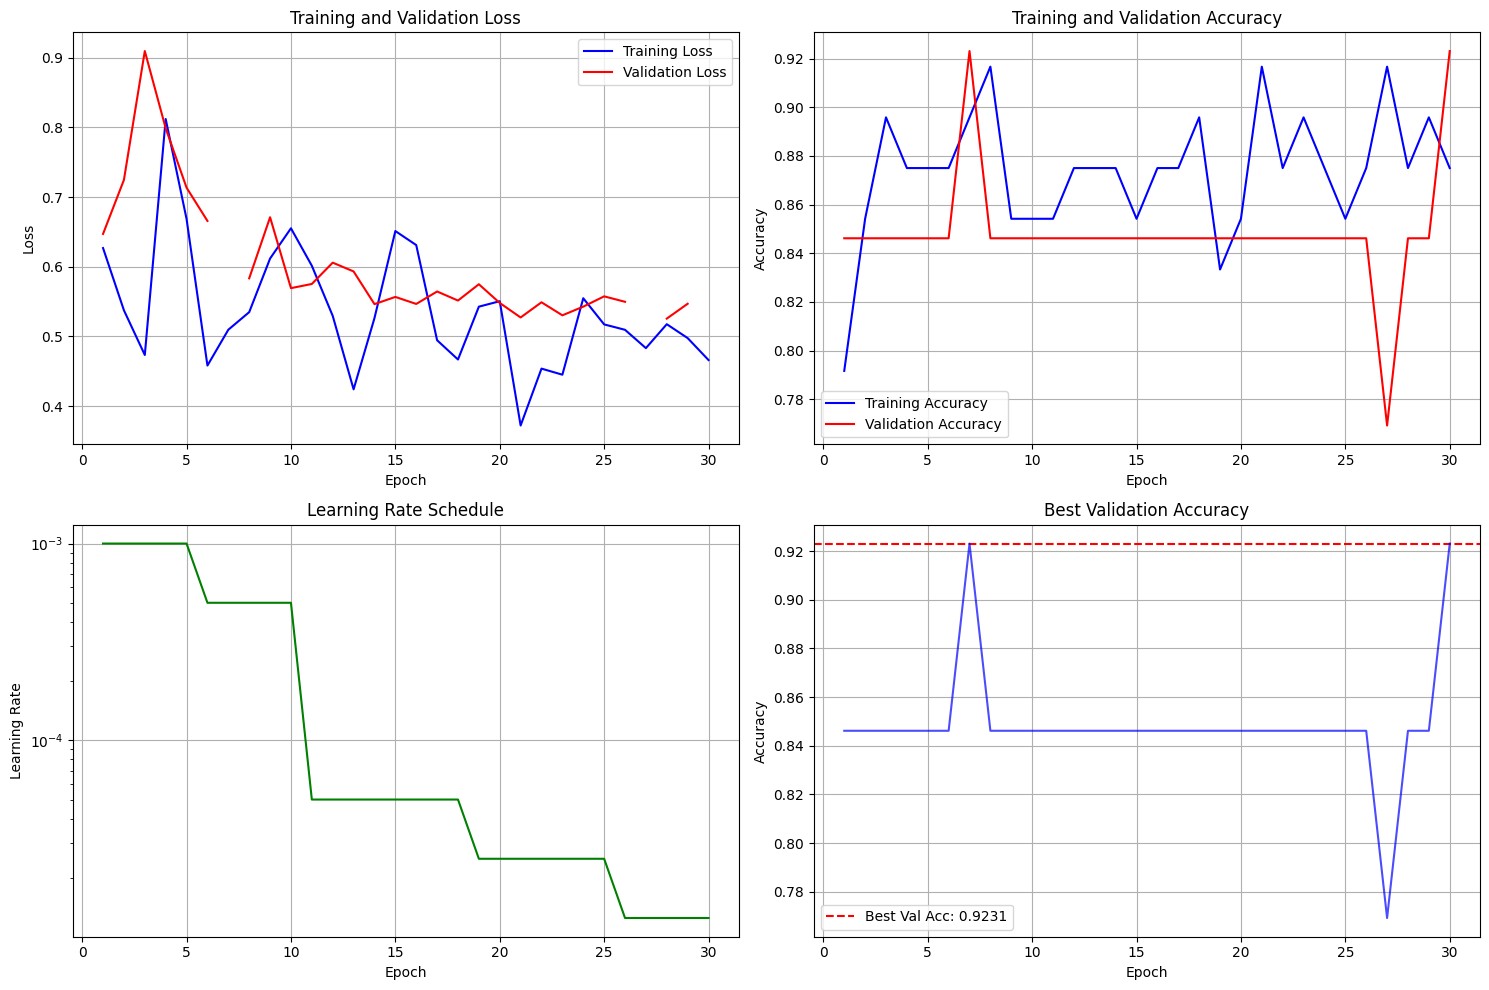

In [26]:
trainer.plot_training_history()  

Loading model from provided checkpoint: ./checkpoints/best_frozen_epoch_7.pth
Generating predictions on validation set...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform
 Applying transform


Validation: 100%|██████████| 5/5 [01:12<00:00, 14.42s/it, Loss=1.9092]
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Confusion matrix saved to: checkpoints/confusion_matrix.png


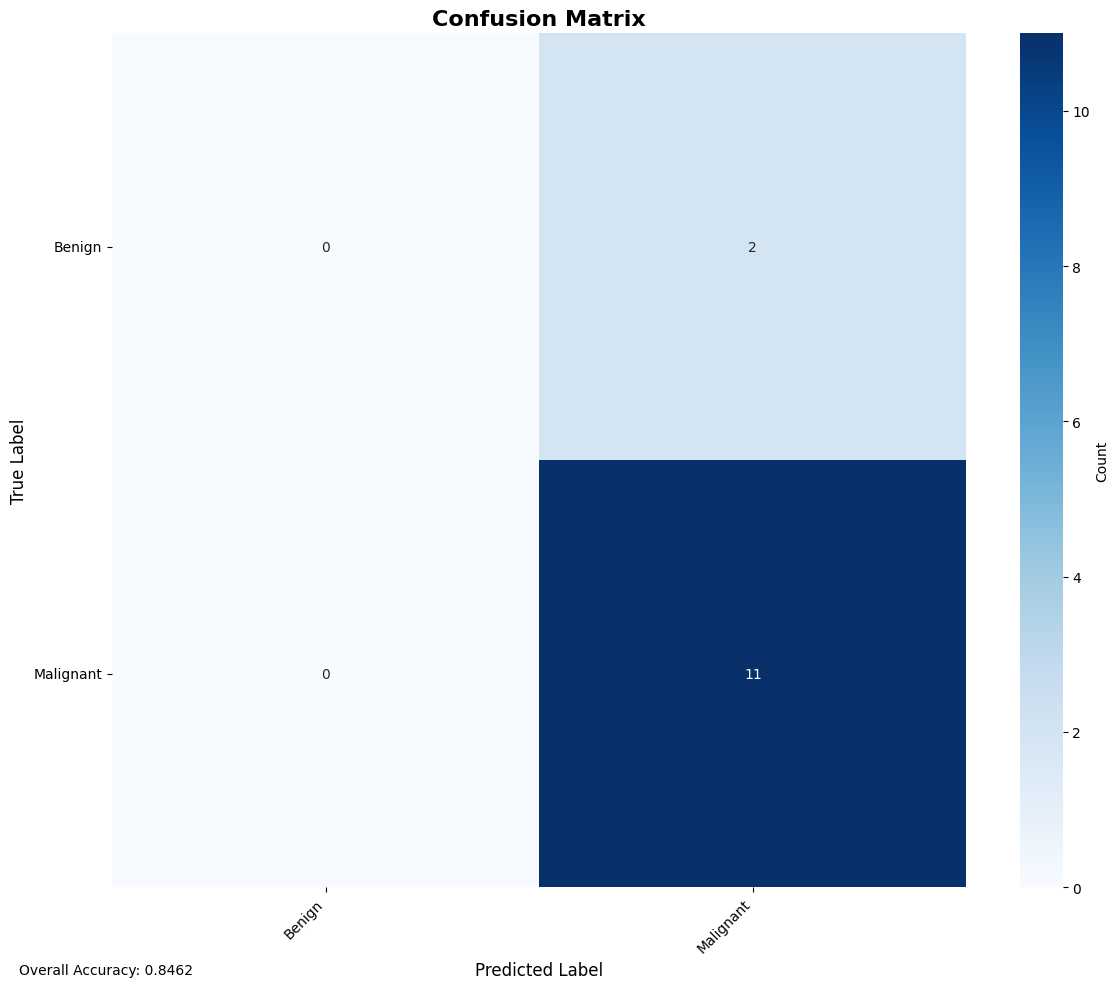


Classification Report:
              precision    recall  f1-score   support

      Benign     0.0000    0.0000    0.0000         2
   Malignant     0.8462    1.0000    0.9167        11

    accuracy                         0.8462        13
   macro avg     0.4231    0.5000    0.4583        13
weighted avg     0.7160    0.8462    0.7756        13


Misclassification Analysis:
Top 10 most common misclassifications:
 1. Benign → Malignant: 2 errors (100.0% of Benign)

Per-class error rates:
Benign: 100.0% error rate (2/2)
Malignant: 0.0% error rate (0/11)


/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/Utkarsh/IMC_classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
from pathlib import Path

def generate_confusion_matrix(trainer, save_dir=None, checkpoint_path=None):
    """
    Generate confusion matrix for the trained model
    
    Args:
        trainer: Your trained IMCTrainer instance
        save_dir: Directory to save the confusion matrix plot
        checkpoint_path: Optional path to specific checkpoint file
    """
    if save_dir is None:
        save_dir = trainer.save_dir
    
    # Try to load the best model or any available checkpoint
    model_loaded = False
    
    # Option 1: Use provided checkpoint path
    if checkpoint_path and Path(checkpoint_path).exists():
        print(f"Loading model from provided checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=trainer.device, weights_only=False)
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        model_loaded = True
    
    # Option 2: Use trainer's best model path
    elif trainer.best_model_path and trainer.best_model_path.exists():
        print(f"Loading best model from: {trainer.best_model_path}")
        checkpoint = torch.load(trainer.best_model_path, map_location=trainer.device, weights_only=False)
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        model_loaded = True
    
    # Option 3: Look for any checkpoint in the save directory
    elif trainer.save_dir.exists():
        checkpoint_files = list(trainer.save_dir.glob("*.pth"))
        if checkpoint_files:
            # Use the most recent checkpoint
            latest_checkpoint = max(checkpoint_files, key=lambda p: p.stat().st_mtime)
            print(f"Loading latest checkpoint found: {latest_checkpoint}")
            checkpoint = torch.load(latest_checkpoint, map_location=trainer.device, weights_only=False)
            trainer.model.load_state_dict(checkpoint['model_state_dict'])
            model_loaded = True
    
    # Option 4: Use current model state (if no checkpoints available)
    if not model_loaded:
        print("⚠️  No checkpoints found - using current model state")
        print("   (Results may not be optimal if training was interrupted early)")
    
    # Get validation predictions
    print("Generating predictions on validation set...")
    val_results = trainer.validate_epoch()
    
    y_true = val_results['labels']
    y_pred = val_results['predictions']
    
    # Get class names if available
    class_names = None
    if 'class_names' in trainer.dataset_info:
        class_names = trainer.dataset_info['class_names']
    elif 'label_to_class' in trainer.dataset_info:
        # Create class names from label mapping
        label_to_class = trainer.dataset_info['label_to_class']
        class_names = [label_to_class[i] for i in range(len(label_to_class))]
    else:
        # Default to class indices
        class_names = [f'Class {i}' for i in range(trainer.dataset_info['num_classes'])]
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(12, 10))
    
    # Plot confusion matrix
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add accuracy to the plot
    accuracy = val_results['accuracy']
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.4f}', 
                fontsize=10, ha='left')
    
    plt.tight_layout()
    
    # Save the plot
    save_path = Path(save_dir) / 'confusion_matrix.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print("=" * 60)
    report = classification_report(y_true, y_pred, 
                                 target_names=class_names, 
                                 digits=4)
    print(report)
    
    # Analyze misclassifications
    print("\nMisclassification Analysis:")
    print("=" * 60)
    analyze_misclassifications(cm, class_names, y_true, y_pred)
    
    return cm, y_true, y_pred

def analyze_misclassifications(cm, class_names, y_true, y_pred):
    """
    Analyze and report the most common misclassifications
    """
    num_classes = len(class_names)
    
    # Find most confused pairs
    confused_pairs = []
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                confused_pairs.append((i, j, cm[i, j]))
    
    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("Top 10 most common misclassifications:")
    for i, (true_idx, pred_idx, count) in enumerate(confused_pairs[:10]):
        true_class = class_names[true_idx]
        pred_class = class_names[pred_idx]
        total_true = cm[true_idx, :].sum()
        error_rate = (count / total_true) * 100
        print(f"{i+1:2d}. {true_class} → {pred_class}: {count} errors ({error_rate:.1f}% of {true_class})")
    
    # Class-wise error analysis
    print(f"\nPer-class error rates:")
    for i, class_name in enumerate(class_names):
        total_samples = cm[i, :].sum()
        correct_samples = cm[i, i]
        error_rate = ((total_samples - correct_samples) / total_samples) * 100
        print(f"{class_name}: {error_rate:.1f}% error rate ({total_samples - correct_samples}/{total_samples})")

def plot_normalized_confusion_matrix(cm, class_names, save_dir=None):
    """
    Plot normalized confusion matrix (percentages)
    """
    # Normalize by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.3f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Proportion'})
    
    plt.title('Normalized Confusion Matrix (Row-wise)', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_dir:
        save_path = Path(save_dir) / 'confusion_matrix_normalized.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Normalized confusion matrix saved to: {save_path}")
    
    plt.show()

# Usage examples for different scenarios:

# Scenario 1: Training completed normally
"""
print("Generating confusion matrix...")
cm, y_true, y_pred = generate_confusion_matrix(trainer)
"""
# Scenario 2: Training was interrupted, but you have your trainer object
"""
# This will automatically find and load the best available checkpoint
print("Generating confusion matrix from interrupted training...")
cm, y_true, y_pred = generate_confusion_matrix(trainer)
"""

# Scenario 3: You want to use a specific checkpoint
"""
# Point to a specific checkpoint file
checkpoint_path = "./checkpoints/best_frozen_epoch_5.pth"
print("Generating confusion matrix from specific checkpoint...")
cm, y_true, y_pred = generate_confusion_matrix(trainer, checkpoint_path=checkpoint_path)
"""

# Scenario 4: You need to recreate everything from scratch
"""
# If you lost your trainer object, you can recreate it and load a checkpoint
model = create_simple_model(
    num_markers=62,
    num_classes=dataset_info['num_classes'],
    pretrained=True,
    shared_backbone=True,
    feature_dim=64,
    dropout_rate=0.6,
    device=device
)

trainer = IMCTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    dataset_info=dataset_info,
    device=device,
    save_dir='./checkpoints'
)
"""
 #Load specific checkpoint
checkpoint_path = "./checkpoints/best_frozen_epoch_7.pth"
cm, y_true, y_pred = generate_confusion_matrix(trainer, checkpoint_path=checkpoint_path)
